In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
DATA_DIR = '../input/data/'
image_size = 256
batch_size = 32

## Data preprocessing

### Preprocessing Metadata

In [ ]:
df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017.csv')

In [ ]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', '*', '*.png'))}

In [ ]:
df['path'] = df['Image Index'].map(data_image_paths.get)

In [ ]:
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [ ]:
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]

In [ ]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [ ]:
for label in labels:
    if len(label) > 1:
        df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)

In [ ]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
labels = [label for label in labels if df[label].sum() > 1000]

In [ ]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=2018, stratify=df['Finding Labels'].map(lambda x: x[:4]))

In [ ]:
train_df['labels'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['labels'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Define DataGenerator

In [ ]:
core_idg = ImageDataGenerator(rescale=1 / 255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.05,
                                  width_shift_range=0.1,
                                  rotation_range=5,
                                  shear_range=0.1,
                                  fill_mode='reflect',
                                  zoom_range=0.15)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                       directory=None,
                                                       x_col='path',
                                                       y_col='labels',
                                                       class_mode='categorical',
                                                       batch_size=1024,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

Found 41318 validated image filenames belonging to 13 classes.
Found 10331 validated image filenames belonging to 13 classes.
Found 10331 validated image filenames belonging to 13 classes.


## Create model

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation="sigmoid")(x)
model = tf.keras.Model(base_model.input, output)
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

219062272/219055592 [==============================] - 15s 0us/step


In [ ]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'model.{model_name}.h5',
        verbose=1,
        save_best_only=True)
    # erly = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    callbacks.append(checkpoint)
    # callbacks.append(erly)
    return callbacks

## Train model

In [ ]:
callbacks = get_callbacks('inceptionresnetv2')
model.fit(train_gen,
              steps_per_epoch=100,
              validation_data=(test_X, test_Y),
              epochs=50,
              callbacks=callbacks)

Train for 100 steps, validate on 1024 samples
Epoch 1/50
 99/100 [============================>.] - ETA: 1s - loss: 0.3398 - accuracy: 0.8696
Epoch 00001: val_loss improved from inf to 0.43011, saving model to model.inceptionresnetv2.h5
100/100 [==============================] - 188s 2s/step - loss: 0.3394 - accuracy: 0.8697 - val_loss: 0.4301 - val_accuracy: 0.8310
Epoch 2/50
 99/100 [============================>.] - ETA: 1s - loss: 0.3154 - accuracy: 0.8800
Epoch 00002: val_loss improved from 0.43011 to 0.39485, saving model to model.inceptionresnetv2.h5
100/100 [==============================] - 143s 1s/step - loss: 0.3157 - accuracy: 0.8800 - val_loss: 0.3948 - val_accuracy: 0.8456
Epoch 3/50
 99/100 [============================>.] - ETA: 1s - loss: 0.3099 - accuracy: 0.8811
Epoch 00003: val_loss improved from 0.39485 to 0.32207, saving model to model.inceptionresnetv2.h5
100/100 [==============================] - 141s 1s/step - loss: 0.3096 - accuracy: 0.8813 - val_loss: 0.3221 

Epoch 29/50
 99/100 [============================>.] - ETA: 1s - loss: 0.2713 - accuracy: 0.8914
Epoch 00029: val_loss did not improve from 0.26914
100/100 [==============================] - 126s 1s/step - loss: 0.2712 - accuracy: 0.8914 - val_loss: 0.2768 - val_accuracy: 0.8932
Epoch 30/50
 99/100 [============================>.] - ETA: 1s - loss: 0.2744 - accuracy: 0.8924
Epoch 00030: val_loss did not improve from 0.26914
100/100 [==============================] - 125s 1s/step - loss: 0.2743 - accuracy: 0.8924 - val_loss: 0.2901 - val_accuracy: 0.8929
Epoch 31/50
 99/100 [============================>.] - ETA: 1s - loss: 0.2715 - accuracy: 0.8944
Epoch 00031: val_loss did not improve from 0.26914
100/100 [==============================] - 125s 1s/step - loss: 0.2710 - accuracy: 0.8945 - val_loss: 0.2835 - val_accuracy: 0.8898
Epoch 32/50
 99/100 [============================>.] - ETA: 1s - loss: 0.2667 - accuracy: 0.8952
Epoch 00032: val_loss did not improve from 0.26914
100/100 [===

In [ ]:
y_pred = model.predict(test_X)

In [ ]:
for label, p_count, t_count in zip(labels,
                                     100 * np.mean(y_pred, 0),
                                     100 * np.mean(test_Y, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (label, t_count, p_count))

Atelectasis: actual: 21.09%, predicted: 16.21%
Cardiomegaly: actual: 5.08%, predicted: 4.81%
Consolidation: actual: 8.50%, predicted: 6.71%
Edema: actual: 3.42%, predicted: 1.59%
Effusion: actual: 24.22%, predicted: 28.34%
Emphysema: actual: 5.08%, predicted: 3.16%
Fibrosis: actual: 4.39%, predicted: 4.17%
Infiltration: actual: 37.99%, predicted: 35.84%
Mass: actual: 10.06%, predicted: 19.02%
Nodule: actual: 11.43%, predicted: 14.31%
Pleural_Thickening: actual: 6.84%, predicted: 12.13%
Pneumonia: actual: 2.64%, predicted: 2.24%
Pneumothorax: actual: 10.16%, predicted: 4.55%


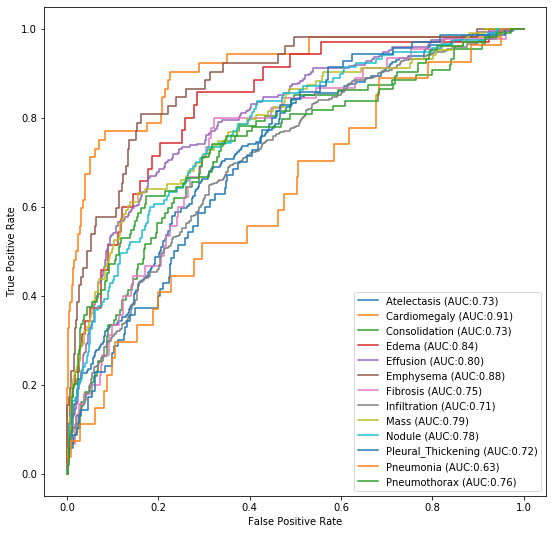

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [ ]:
print('ROC auc score: {:.3f}'.format(roc_auc_score(test_Y.astype(int), y_pred)))

ROC auc score: 0.771
